In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/caltech/caltech-101/show_annotation.m
/kaggle/input/caltech/caltech-101/Annotations/Annotations/check_progress.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/FeatureDetectionQuality.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/README
/kaggle/input/caltech/caltech-101/Annotations/Annotations/progress.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/README~
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0346.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0137.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0308.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0395.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0427.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/annotation_0056.mat
/kaggle/input/caltech/caltech-101/Annotations/Annotations/Faces_2/a

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=4a78b4d82bf535f479b1f9f09a813e8df17c040d43fbf8b0ed05a57459e10f1e
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import time
import os
import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Using device: cuda


In [5]:
from sklearn.model_selection import train_test_split
import shutil
import os

# Original dataset path
original_data_dir = '/kaggle/input/caltech/caltech-101/101_ObjectCategories/101_ObjectCategories'

# New dataset directories
base_dir = '/kaggle/working/caltech_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop through classes
for class_name in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Dataset split completed!")


Dataset split completed!


In [6]:
data_dir = '/kaggle/working/caltech_split'

# Debugging the dataset path
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset directory not found at {data_dir}")

# Check subdirectories
for phase in ['train', 'val']:
    phase_dir = os.path.join(data_dir, phase)
    if not os.path.exists(phase_dir):
        raise FileNotFoundError(f"{phase.capitalize()} directory not found: {phase_dir}")
    print(f"Found {phase} directory with {len(os.listdir(phase_dir))} classes.")


Found train directory with 102 classes.
Found val directory with 102 classes.


In [7]:
# Define data directories
data_dir = '/kaggle/working/caltech_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")

Classes: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'sn

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model  # Ensure only the model is returned, not a tuple


In [13]:
# Define function to visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0).numpy())

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
# List of models to train and evaluate
models_to_train = {
    'VGG19': models.vgg19(weights=models.VGG19_Weights.DEFAULT),
    'ResNet50': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'EfficientNet-B0': models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
}

Training VGG19
Epoch 1/10
----------
train Loss: 1.9155 Acc: 0.5493
val Loss: 0.5830 Acc: 0.8348
Epoch 2/10
----------
train Loss: 0.9705 Acc: 0.7374
val Loss: 0.4941 Acc: 0.8541
Epoch 3/10
----------
train Loss: 0.7893 Acc: 0.7850
val Loss: 0.4452 Acc: 0.8777
Epoch 4/10
----------
train Loss: 0.6972 Acc: 0.8038
val Loss: 0.4663 Acc: 0.8648
Epoch 5/10
----------
train Loss: 0.6287 Acc: 0.8217
val Loss: 0.4188 Acc: 0.8809
Epoch 6/10
----------
train Loss: 0.5716 Acc: 0.8386
val Loss: 0.4355 Acc: 0.8809
Epoch 7/10
----------
train Loss: 0.5551 Acc: 0.8402
val Loss: 0.4002 Acc: 0.8868
Epoch 8/10
----------
train Loss: 0.4385 Acc: 0.8747
val Loss: 0.3424 Acc: 0.9029
Epoch 9/10
----------
train Loss: 0.3897 Acc: 0.8885
val Loss: 0.3386 Acc: 0.9061
Epoch 10/10
----------
train Loss: 0.3626 Acc: 0.8968
val Loss: 0.3340 Acc: 0.9126
Training complete in 12m 4s
Best val Acc: 0.9126
Model VGG19 saved successfully!
Training ResNet50
Epoch 1/10
----------
train Loss: 3.4728 Acc: 0.2843
val Loss: 2.

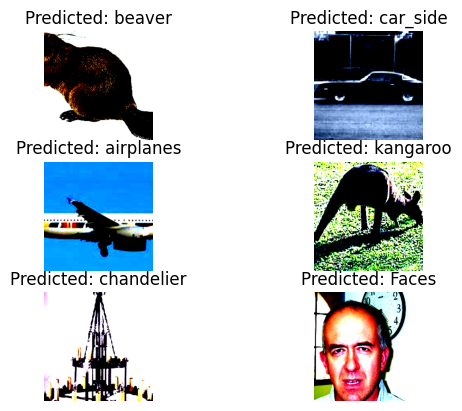

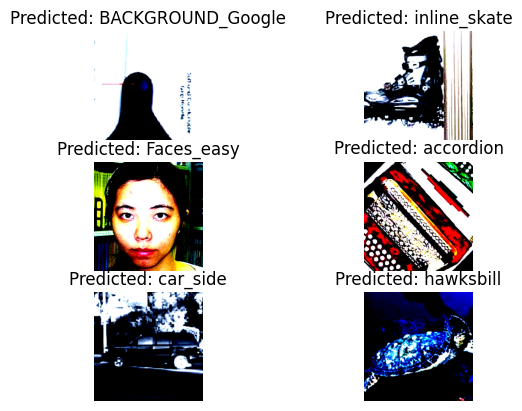

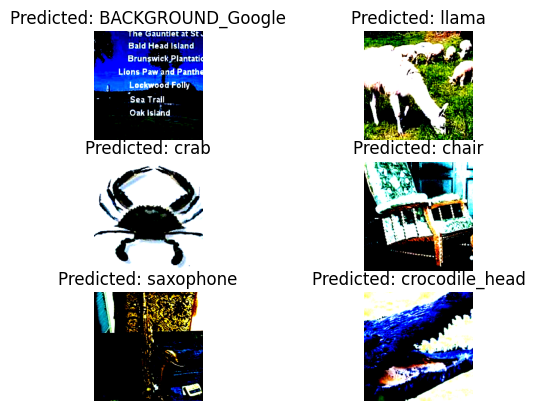

In [15]:
for model_name, model in models_to_train.items():
    print(f"Training {model_name}")  

    # Modify the final layer for Caltech-101 classes
    if hasattr(model, 'fc'):  # For models like ResNet
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
    elif hasattr(model, 'classifier'):  # For models like DenseNet or ShuffleNet
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))

    # Move the model to the device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_caltech101.pth')
    print(f"Model {model_name} saved successfully!")

    # Visualize predictions
    visualize_model(model)


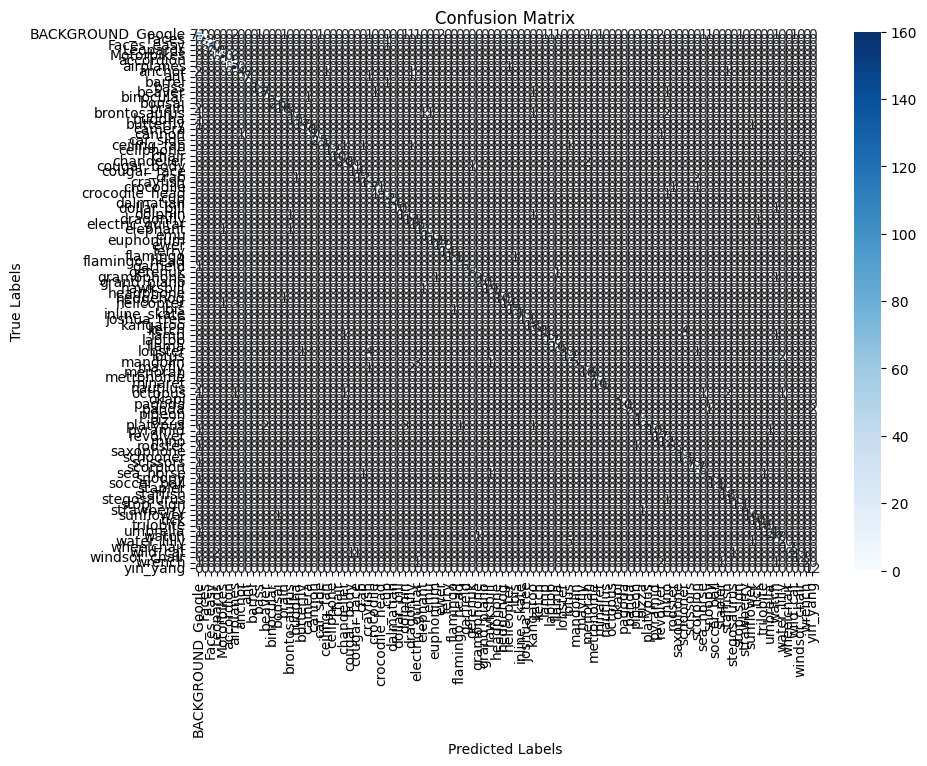

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate through the data
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())  # Move to CPU for later processing
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the confusion matrix function on the validation set after training
plot_confusion_matrix(model, dataloaders['val'], class_names)


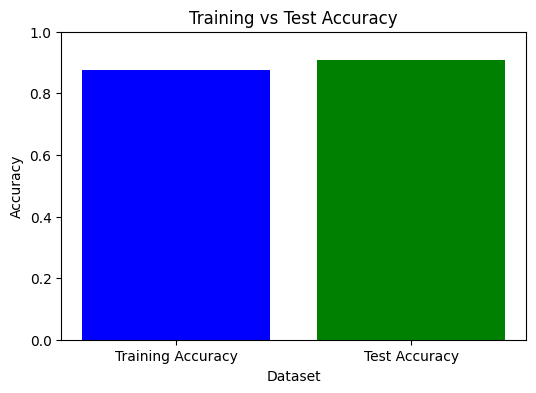

In [17]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

# Function to calculate accuracy for a given dataset (train or test)
def calculate_accuracy(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate through the data
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())  # Store predictions
            all_labels.append(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Calculate accuracy for training and validation datasets
train_accuracy = calculate_accuracy(model, dataloaders['train'])
val_accuracy = calculate_accuracy(model, dataloaders['val'])

# Create a bar chart to compare the accuracies
accuracies = [train_accuracy, val_accuracy]
labels = ['Training Accuracy', 'Test Accuracy']

# Plotting the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.title('Training vs Test Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


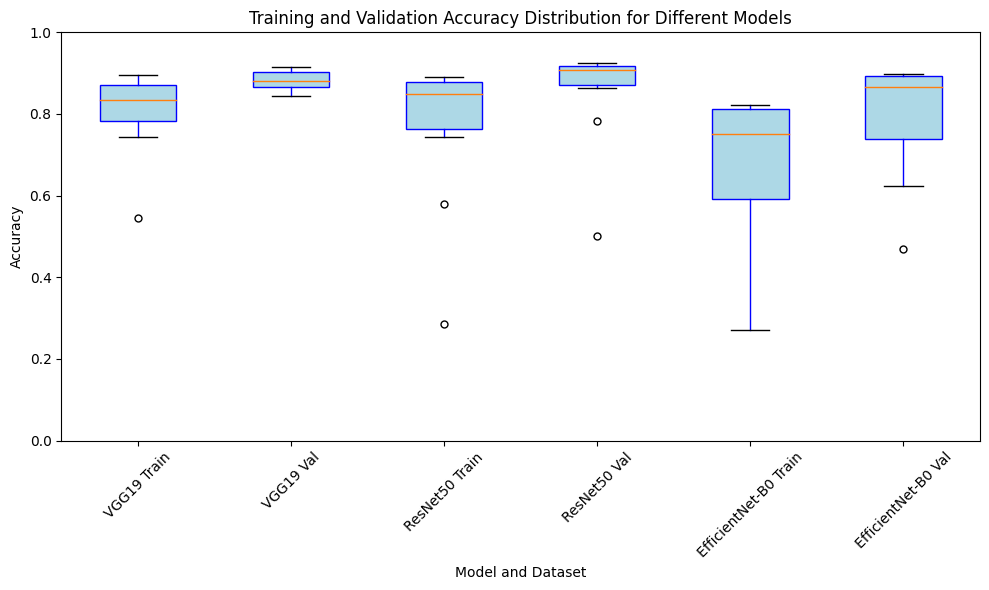

In [18]:
import matplotlib.pyplot as plt

vgg19_train_accuracies = [0.5441, 0.7442, 0.7750, 0.8044, 0.8271, 0.8400, 0.8516, 0.8790, 0.8882, 0.8956]
vgg19_val_accuracies = [0.8460, 0.8433, 0.8653, 0.8771, 0.8868, 0.8686, 0.8852, 0.9131, 0.9083, 0.9142]

resnet50_train_accuracies = [0.2852, 0.5786, 0.7437, 0.8180, 0.8391, 0.8582, 0.8745, 0.8801, 0.8897, 0.8852]
resnet50_val_accuracies = [0.5000, 0.7817, 0.8632, 0.8975, 0.9088, 0.9088, 0.9115, 0.9206, 0.9238, 0.9238]

efficientnetb0_train_accuracies = [0.2716, 0.4459, 0.5677, 0.6628, 0.7288, 0.7746, 0.8048, 0.8217, 0.8162, 0.8218]
efficientnetb0_val_accuracies = [0.4700, 0.6245, 0.7200, 0.7918, 0.8546, 0.8761, 0.8986, 0.8922, 0.8981, 0.8943]

# Create a list of accuracies for each model
data = [
    vgg19_train_accuracies, vgg19_val_accuracies,
    resnet50_train_accuracies, resnet50_val_accuracies,
    efficientnetb0_train_accuracies, efficientnetb0_val_accuracies
]

# Create a list of labels for each box (for the legend)
labels = [
    'VGG19 Train', 'VGG19 Val',
    'ResNet50 Train', 'ResNet50 Val',
    'EfficientNet-B0 Train', 'EfficientNet-B0 Val'
]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            flierprops=dict(marker='o', color='red', markersize=5))

# Adding title and labels
plt.title('Training and Validation Accuracy Distribution for Different Models')
plt.xlabel('Model and Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


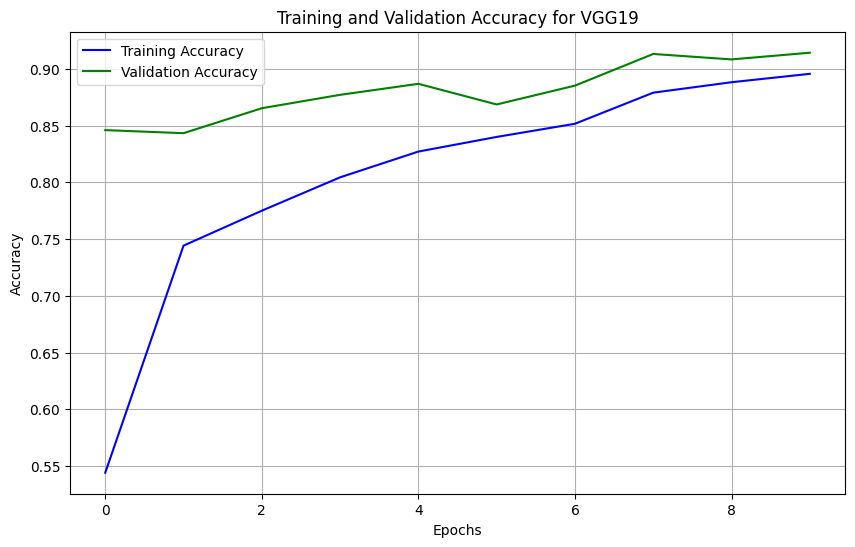

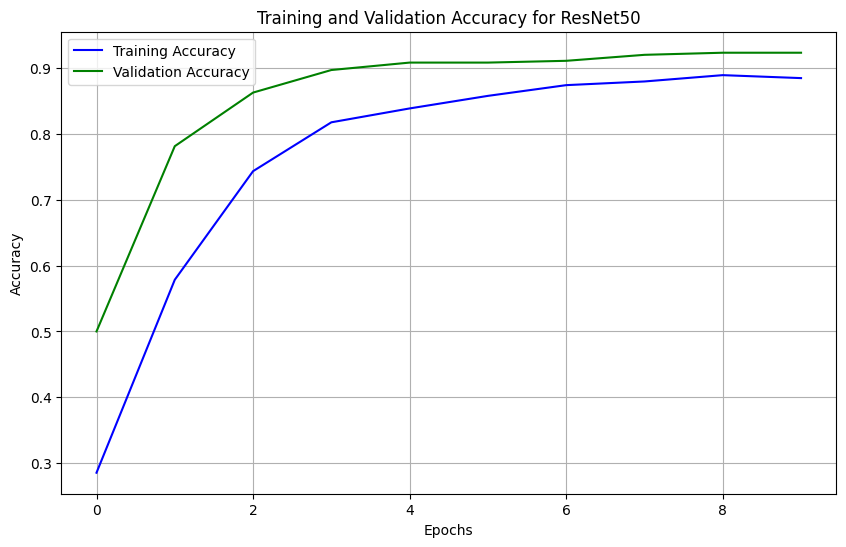

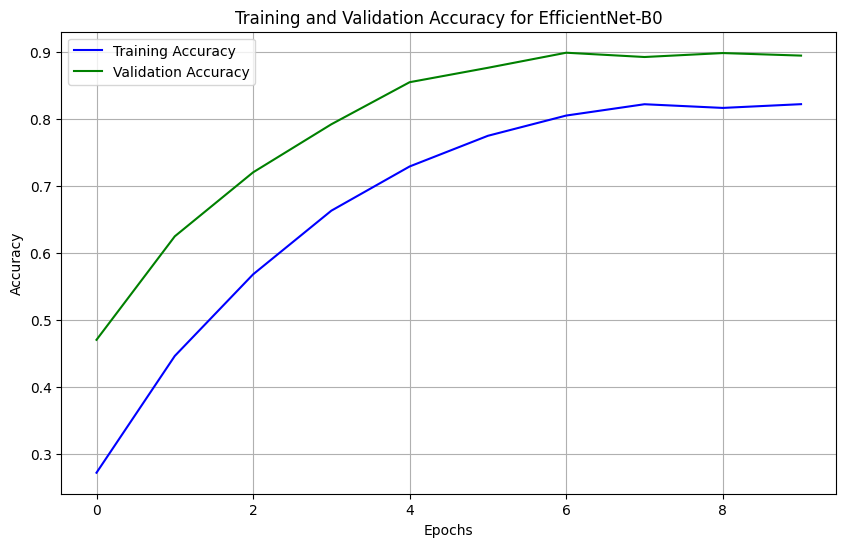

In [19]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='green')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_accuracy(vgg19_train_accuracies, vgg19_val_accuracies, 'VGG19')
plot_accuracy(resnet50_train_accuracies, resnet50_val_accuracies, 'ResNet50')
plot_accuracy(efficientnetb0_train_accuracies, efficientnetb0_val_accuracies, 'EfficientNet-B0')

In [ ]:
pip install torch torchvision matplotlib numpy opencv-python

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = []
        self.gradients = []

        # Hook to store the feature maps
        self.hook = self.target_layer.register_forward_hook(self.save_feature_maps)
        
        # Hook to store the gradients
        self.gradient_hook = self.target_layer.register_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        self.feature_maps.append(output)

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients.append(grad_out[0])

    def forward(self, x):
        return self.model(x)

    def generate_cam(self, class_idx):
        # Get the gradients and feature maps
        gradients = self.gradients[0]
        feature_maps = self.feature_maps[0]

        # Calculate the weights
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
        cam = F.relu(cam)

        # Resize the cam to the size of the input image
        cam = cam.squeeze().cpu().detach().numpy()
        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (224, 224))  # Resize to match input size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)  # Normalize
        return cam

In [21]:
def plot_gradcam(model, image, class_idx, target_layer):
    grad_cam = GradCAM(model, target_layer)
    
    # Forward pass to get predictions
    image = image.unsqueeze(0).to(device)
    output = model(image)
    
    # Backward pass to get gradients
    model.zero_grad()
    output[0, class_idx].backward()

    # Generate Grad-CAM
    cam = grad_cam.generate_cam(class_idx)

    # Visualize Grad-CAM on the image
    image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    # Overlay the Grad-CAM heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_overlay = 0.5 * heatmap + 0.5 * image

    # Plot the result
    plt.figure(figsize=(10, 10))
    plt.imshow(cam_overlay)
    plt.title(f'Grad-CAM Visualization for Class Index {class_idx}')
    plt.axis('off')
    plt.show()

In [24]:
import torch
import torchvision.models as models

# Assuming class_names is defined
num_classes = len(class_names)

# Initialize the models with pretrained weights
vgg19_model = models.vgg19(pretrained=True)
resnet50_model = models.resnet50(pretrained=True)
efficientnetb0_model = models.efficientnet_b0(pretrained=True)

# Modify the final fully connected layer for the number of classes
vgg19_model.classifier[6] = torch.nn.Linear(vgg19_model.classifier[6].in_features, num_classes)
resnet50_model.fc = torch.nn.Linear(resnet50_model.fc.in_features, num_classes)
efficientnetb0_model.classifier[1] = torch.nn.Linear(efficientnetb0_model.classifier[1].in_features, num_classes)

# Move the models to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)
resnet50_model.to(device)
efficientnetb0_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
from torchvision import datasets, transforms

# Define your transforms for test dataset (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='/kaggle/input/caltech/caltech-101/101_ObjectCategories/101_ObjectCategories', transform=transform)


In [33]:
from torch.utils.data import DataLoader

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Accuracy: 89.21%


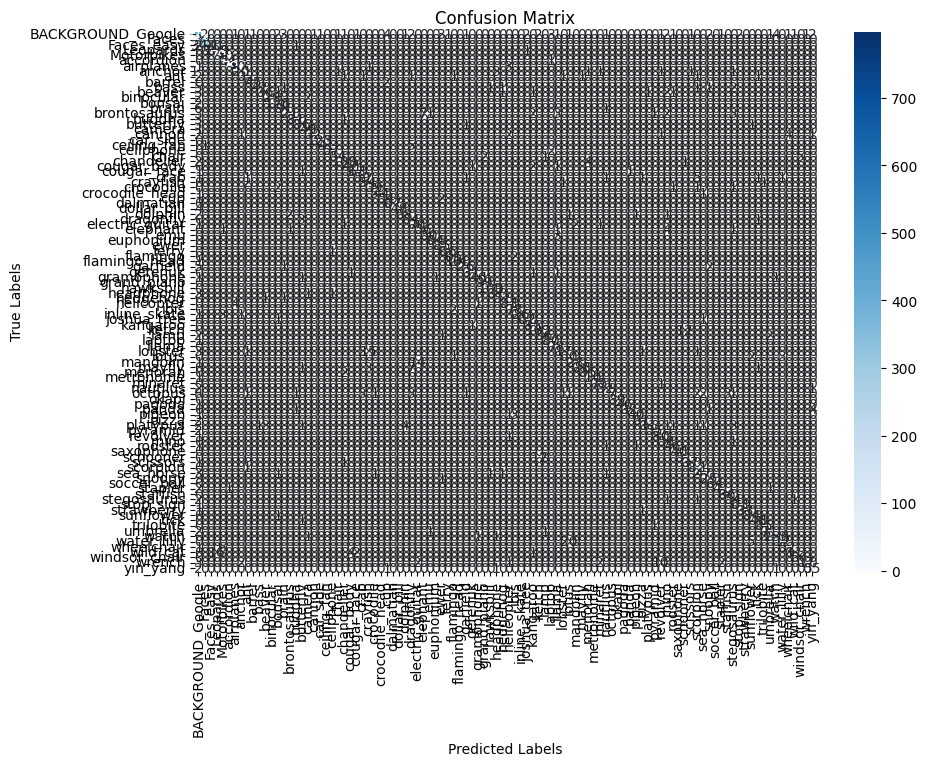

In [35]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the transformations for the test set
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='/kaggle/input/caltech/caltech-101/101_ObjectCategories/101_ObjectCategories', transform=transform)

# Create the DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming you already have a trained model and it's on the correct device
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class labels

        # Store the predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [36]:
import torch
from sklearn.metrics import classification_report
import numpy as np

# Assuming you have a trained model and test_loader

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare lists to store true labels and predictions
y_true = []
y_pred = []

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class labels

        # Append to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Assuming 'class_names' is a list of class labels
class_names = test_loader.dataset.classes  # Get class names from the dataset

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.76      0.88      0.82       467
            Faces       0.56      0.99      0.71       435
       Faces_easy       1.00      0.21      0.35       435
         Leopards       0.93      0.99      0.96       200
       Motorbikes       0.99      1.00      0.99       798
        accordion       0.98      0.98      0.98        55
        airplanes       0.99      0.99      0.99       800
           anchor       0.83      0.48      0.61        42
              ant       0.80      0.76      0.78        42
           barrel       0.98      0.96      0.97        47
             bass       0.98      0.78      0.87        54
           beaver       0.80      0.78      0.79        46
        binocular       1.00      0.88      0.94        33
           bonsai       0.93      0.98      0.96       128
            brain       0.94      0.93      0.93        98
     brontosaurus       0.88      0.49      0.63       

In [44]:
import torch

def top_k_accuracy(output, target, k=5):
   
    with torch.no_grad():  # Disable gradient calculation for inference
        # Get the top-k predictions
        max_k_preds = torch.topk(output, k, dim=1).indices
        # Check if the true label is in the top-k predictions
        correct = max_k_preds.eq(target.view(-1, 1).expand_as(max_k_preds))
        # Calculate the top-k accuracy
        return correct.any(dim=1).float().mean().item()

# Example usage
# Assume model outputs and true labels
output = torch.randn(32, 10)  # Example output for a batch of 32 samples with 10 classes
target = torch.randint(0, 10, (32,))  # Example true labels for a batch of 32 samples

# Compute the top-5 accuracy
accuracy = top_k_accuracy(output, target, k=5)
print(f"Top-5 accuracy: {accuracy:.4f}")


Top-5 accuracy: 0.5625


In [47]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have a trained model and a dataloader for validation or test
model.eval()  # Set the model to evaluation mode

# Create empty lists to store the true labels and predictions
true_labels = []
predicted_labels = []

# Iterate over the validation/test data
with torch.no_grad():
    for images, labels in dataloaders['val']:  # Replace with your dataloader name
        images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
        
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted labels (max probability)
        
        true_labels.extend(labels.cpu().numpy())  # Store true labels
        predicted_labels.extend(preds.cpu().numpy())  # Store predicted labels

# Convert lists to numpy arrays for sklearn functions
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix and its shape for debugging
print("Confusion Matrix:")
print(cm)
print("Confusion Matrix Shape:", cm.shape)

# Verify the length of `class_names`
print("Length of class_names:", len(class_names))

# If the length of `class_names` does not match the number of classes, you can adjust it
if len(class_names) != cm.shape[0]:
    print(f"Warning: Number of classes in `class_names` does not match the confusion matrix size. Check the length of `class_names`.")

# Calculate per-class accuracy (diagonal / sum of rows)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Iterate over each class in the confusion matrix and display the accuracy
for i, acc in enumerate(per_class_accuracy):
    if i < len(class_names):
        print(f"Class {class_names[i]} Accuracy: {acc:.2f}")
    else:
        print(f"Class {i} Accuracy: {acc:.2f}")  # If there is an index mismatch, use the class index


Confusion Matrix:
[[71  0  0 ...  0  0  0]
 [ 0 78  8 ...  0  0  0]
 [ 0  3 83 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 1  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0 12]]
Confusion Matrix Shape: (102, 102)
Length of class_names: 3
Class Class A Accuracy: 0.76
Class Class B Accuracy: 0.90
Class Class C Accuracy: 0.95
Class 3 Accuracy: 1.00
Class 4 Accuracy: 1.00
Class 5 Accuracy: 1.00
Class 6 Accuracy: 0.99
Class 7 Accuracy: 0.44
Class 8 Accuracy: 0.78
Class 9 Accuracy: 0.90
Class 10 Accuracy: 1.00
Class 11 Accuracy: 0.70
Class 12 Accuracy: 0.86
Class 13 Accuracy: 1.00
Class 14 Accuracy: 0.90
Class 15 Accuracy: 0.33
Class 16 Accuracy: 0.88
Class 17 Accuracy: 0.89
Class 18 Accuracy: 1.00
Class 19 Accuracy: 0.78
Class 20 Accuracy: 1.00
Class 21 Accuracy: 0.60
Class 22 Accuracy: 1.00
Class 23 Accuracy: 0.77
Class 24 Accuracy: 0.91
Class 25 Accuracy: 0.80
Class 26 Accuracy: 1.00
Class 27 Accuracy: 0.80
Class 28 Accuracy: 0.79
Class 29 Accuracy: 0.70
Class 30 Accuracy: 0.82
Class 31 Accur

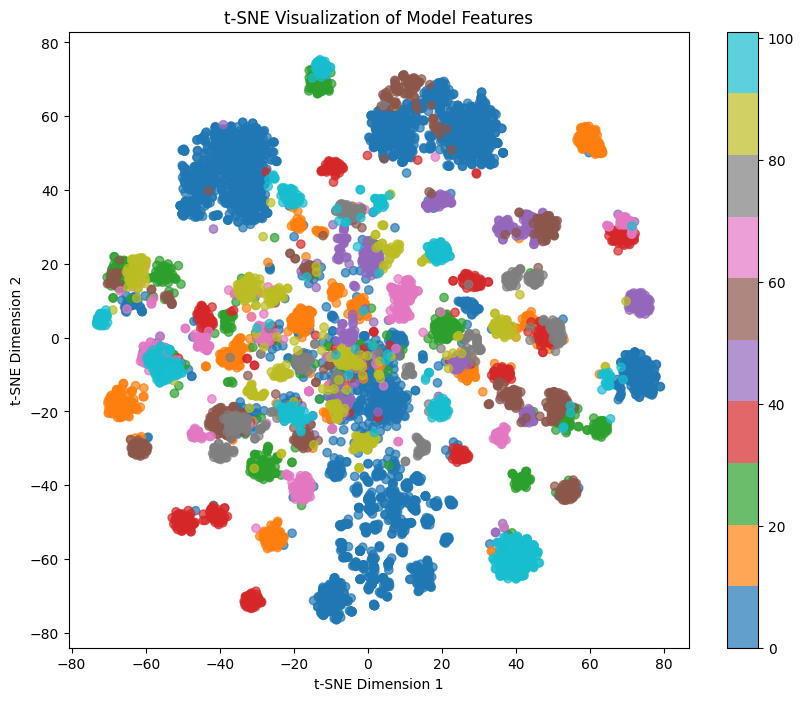

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Assuming `model` is your trained model and `test_loader` is your DataLoader for the test set
features = []
labels_list = []

model.eval()  # Set the model to evaluation mode

# Extract features from an intermediate layer (e.g., before the classifier)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass through the model
        # Replace this with the appropriate feature extraction
        # Example for ResNet50 or VGG19 (before the final classifier layer):
        intermediate_output = model.features(images)  # For models like VGG19
        # intermediate_output = model.layer4[2].conv3(images)  # For ResNet50
        
        # Flatten the output of the convolutional layers (if needed)
        features.append(intermediate_output.view(intermediate_output.size(0), -1))  # Flatten
        labels_list.append(labels)

# Concatenate all features and labels
features = torch.cat(features).cpu().numpy()
labels_list = torch.cat(labels_list).cpu().numpy()

# Apply t-SNE to reduce features to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

# Create a scatter plot of the reduced features
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
plt.colorbar()  # Show color bar
plt.title('t-SNE Visualization of Model Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [58]:
!pip install grad-cam

In [75]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [76]:
device = torch.device("cpu") 
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [90]:
import torch
torch.cuda.empty_cache()

In [91]:
!pip install ultralytics torch torchvision opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 22.8 MB/s eta 0:00:0000:01


In [92]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


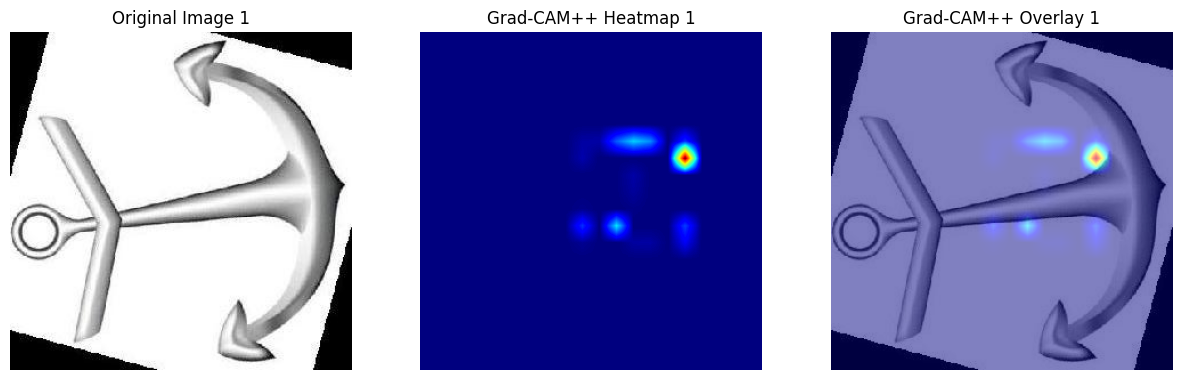

Grad-CAM++ output for image 1 displayed.


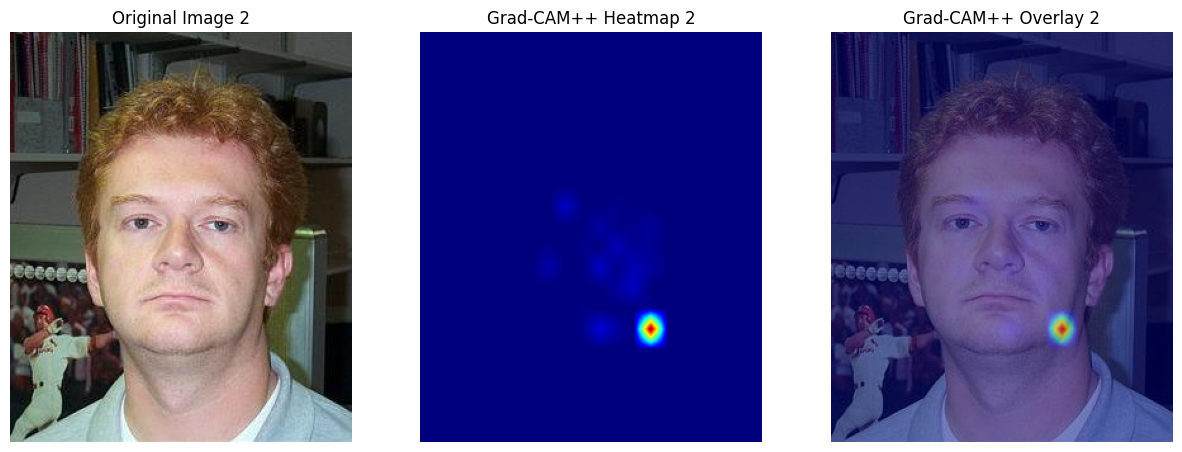

Grad-CAM++ output for image 2 displayed.


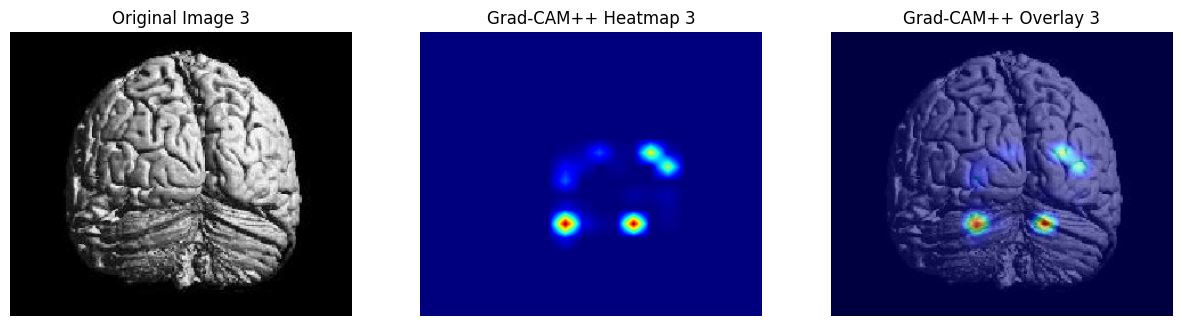

Grad-CAM++ output for image 3 displayed.


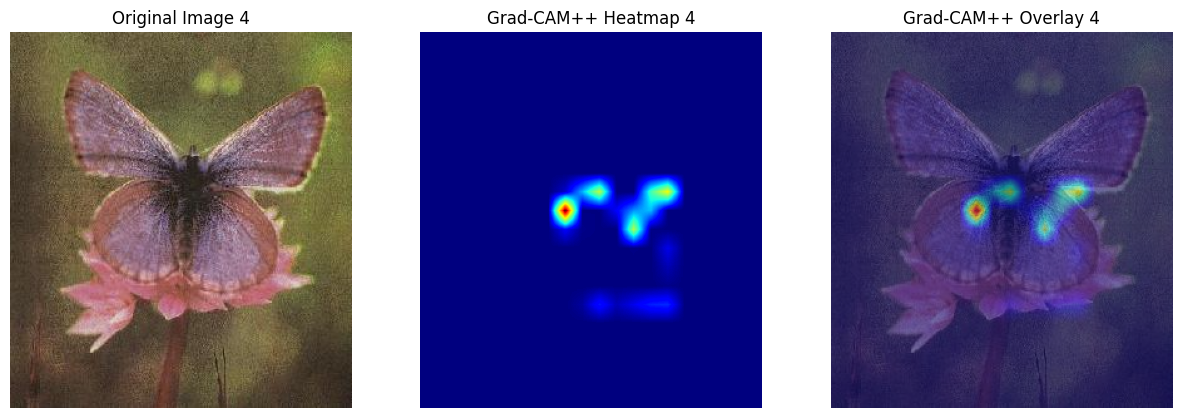

Grad-CAM++ output for image 4 displayed.


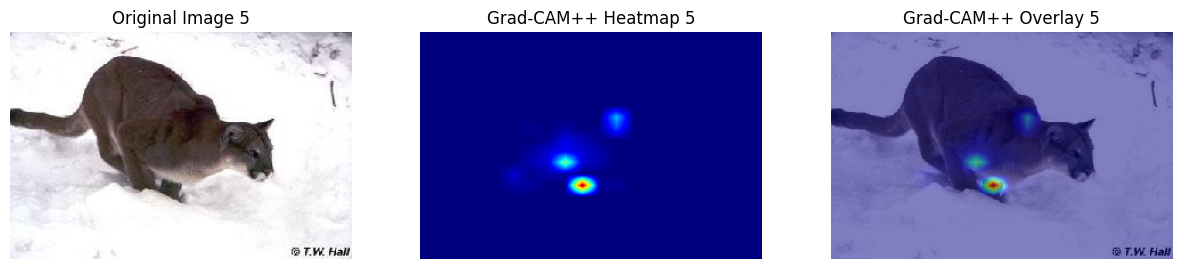

Grad-CAM++ output for image 5 displayed.


In [112]:
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_gradients(self, module, grad_input, grad_output):
        """ Save gradients during backpropagation. """
        self.gradients = grad_output[0]

    def save_feature_maps(self, module, input, output):
        """ Save feature maps during forward pass. """
        self.feature_maps = output

    def generate_cam(self):
        """ Generate Grad-CAM++ heatmap. """
        gradients = self.gradients
        feature_maps = self.feature_maps

        gradients_power_2 = gradients ** 2
        gradients_power_3 = gradients ** 3
        alpha_numer = gradients_power_2
        alpha_denom = (
            2 * gradients_power_2 + torch.sum(feature_maps * gradients_power_3, dim=(2, 3), keepdim=True)
        ).clamp(min=1e-10)
        alpha = alpha_numer / alpha_denom

        weights = alpha * torch.relu(gradients)

        cam = torch.sum(weights * feature_maps, dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize the CAM to the range [0, 1]
        if np.max(cam) != 0:  # Avoid division by zero
            cam = cam / np.max(cam)
        else:
            print("Warning: CAM has all zeros. Skipping normalization.")
        
        return cam


# Update the model path to your custom trained YOLO model
model = YOLO("/kaggle/working/yolov5su.pt")  # CHANGE THIS LINE TO YOUR MODEL'S PATH
model.eval()

torch.set_grad_enabled(True)

# List of image paths (ensure you have at least 5 images)
image_paths = [
    "/kaggle/working/caltech_split/val/anchor/image_0009.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/Faces_easy/image_0023.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/brain/image_0019.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/butterfly/image_0026.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/cougar_body/image_0013.jpg"   # Change to your images
]

# Loop through the images and process them
for i, image_path in enumerate(image_paths):
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue  # Skip to the next image

    # Read and process the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image {image_path}. Skipping...")
        continue  # Skip to the next image

    input_image = cv2.resize(image, (640, 640))
    input_tensor = (
        torch.tensor(input_image.transpose(2, 0, 1))
        .float()
        .unsqueeze(0)
        .div(255.0)
        .requires_grad_()
    )

    # Choose target layer based on your model architecture
    target_layer = model.model.model[-3]  # This is typically the last convolutional layer, but might vary
    grad_cam_plus_plus = GradCAMPlusPlus(model, target_layer)

    # Get model predictions
    output = model.model(input_tensor)

    # Process output from YOLO (get confidence values for each detection)
    raw_predictions = output[0]
    raw_predictions = raw_predictions.permute(0, 2, 1)

    # Extract confidence values
    confidences = raw_predictions[0, :, 4]

    # Get the target score (maximum confidence score)
    target_score = confidences.max()

    # Zero out the gradients and perform a backward pass
    model.zero_grad()
    target_score.backward(retain_graph=True)

    # Generate the Grad-CAM++ heatmap
    heatmap = grad_cam_plus_plus.generate_cam()

    # Resize the heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

    # Show multiple plots: Original Image, Grad-CAM++ Heatmap, and Overlay
    plt.figure(figsize=(15, 15))

    # Plot 1: Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Display original image
    plt.title(f"Original Image {i + 1}")
    plt.axis('off')

    # Plot 2: Grad-CAM++ Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')  # Display Grad-CAM++ heatmap
    plt.title(f"Grad-CAM++ Heatmap {i + 1}")
    plt.axis('off')

    # Plot 3: Overlay Image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Display overlayed Grad-CAM++ image
    plt.title(f"Grad-CAM++ Overlay {i + 1}")
    plt.axis('off')

    plt.show()  # Display all plots

    print(f"Grad-CAM++ output for image {i + 1} displayed.")


In [115]:
# Append each predicted label individually
predicted_labels.extend(predicted_labels_batch.cpu().numpy())  # Use extend to add all labels in the batch

# Detach the tensor from the computation graph and then convert to numpy
confidence_scores.extend(confidences.detach().cpu().numpy())  # Detach and convert to numpy


In [116]:
# Loop through the images and process them
for i, image_path in enumerate(image_paths):
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue  # Skip to the next image

    # Read and process the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image {image_path}. Skipping...")
        continue  # Skip to the next image

    input_image = cv2.resize(image, (640, 640))
    input_tensor = (
        torch.tensor(input_image.transpose(2, 0, 1))
        .float()
        .unsqueeze(0)
        .div(255.0)
        .requires_grad_()
    )

    # Choose target layer based on your model architecture
    target_layer = model.model.model[-3]  # This is typically the last convolutional layer, but might vary
    grad_cam_plus_plus = GradCAMPlusPlus(model, target_layer)

    # Get model predictions
    output = model.model(input_tensor)

    # Process output from YOLO (get confidence values for each detection)
    raw_predictions = output[0]
    raw_predictions = raw_predictions.permute(0, 2, 1)

    # Extract confidence values and predicted labels
    confidences = raw_predictions[0, :, 4]
    predicted_labels_batch = torch.argmax(raw_predictions[0, :, 5:], dim=1)

    # Append each predicted label individually
    predicted_labels.extend(predicted_labels_batch.cpu().numpy())  # Use extend to add all labels in the batch

    # Detach the tensor from the computation graph and then convert to numpy
    confidence_scores.extend(confidences.detach().cpu().numpy())  # Detach and convert to numpy

    # Get the target score (maximum confidence score)
    target_score = confidences.max()

    # Zero out the gradients and perform a backward pass
    model.zero_grad()
    target_score.backward(retain_graph=True)

    # Generate the Grad-CAM++ heatmap
    heatmap = grad_cam_plus_plus.generate_cam()

    # Resize the heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

    # Save the output with overlay
    output_path = f"/kaggle/working/grad_cam_output_{i + 1}.jpg"  # Save with a unique filename
    cv2.imwrite(output_path, overlay)
    print(f"Grad-CAM++ output for image {i + 1} saved at {output_path}")


Grad-CAM++ output for image 1 saved at /kaggle/working/grad_cam_output_1.jpg
Grad-CAM++ output for image 2 saved at /kaggle/working/grad_cam_output_2.jpg
Grad-CAM++ output for image 3 saved at /kaggle/working/grad_cam_output_3.jpg
Grad-CAM++ output for image 4 saved at /kaggle/working/grad_cam_output_4.jpg
Grad-CAM++ output for image 5 saved at /kaggle/working/grad_cam_output_5.jpg


Grad-CAM++ output for image 1 saved at /kaggle/working/grad_cam_output_1.jpg
Grad-CAM++ output for image 2 saved at /kaggle/working/grad_cam_output_2.jpg
Grad-CAM++ output for image 3 saved at /kaggle/working/grad_cam_output_3.jpg
Grad-CAM++ output for image 4 saved at /kaggle/working/grad_cam_output_4.jpg
Grad-CAM++ output for image 5 saved at /kaggle/working/grad_cam_output_5.jpg


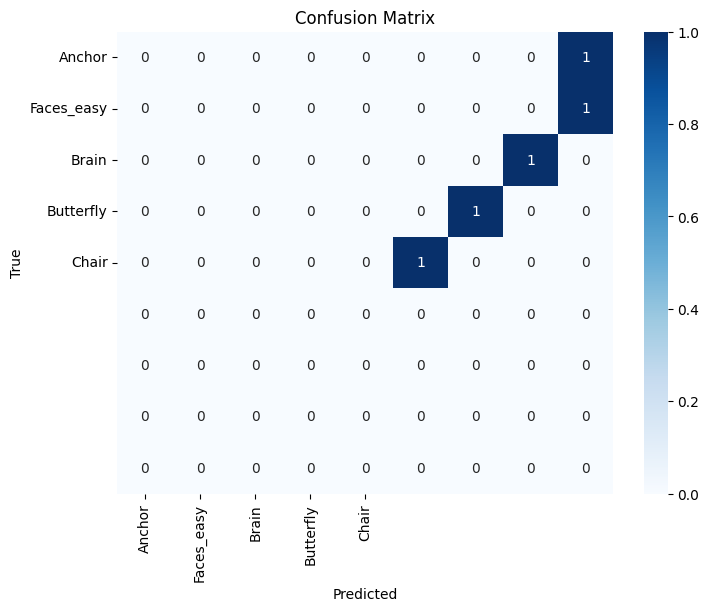

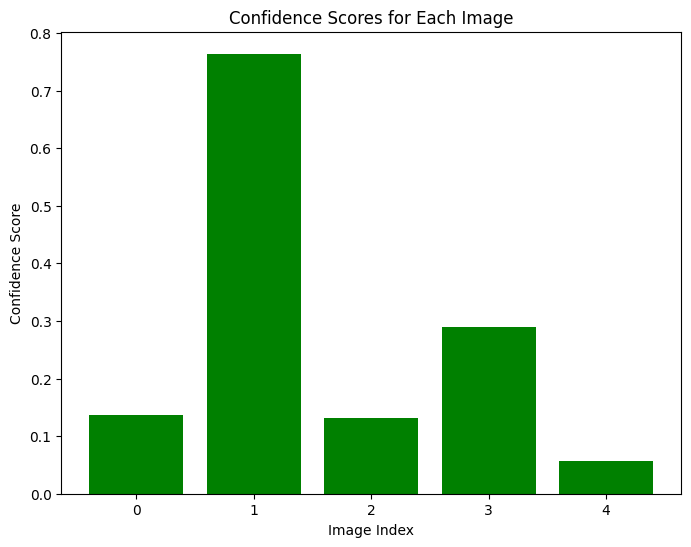

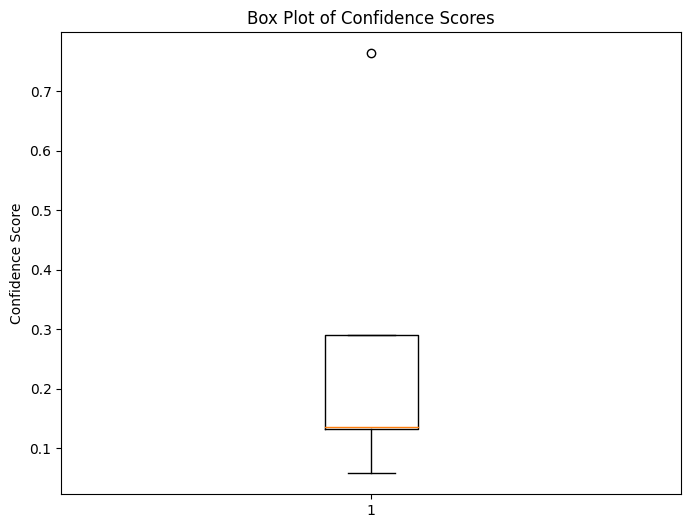

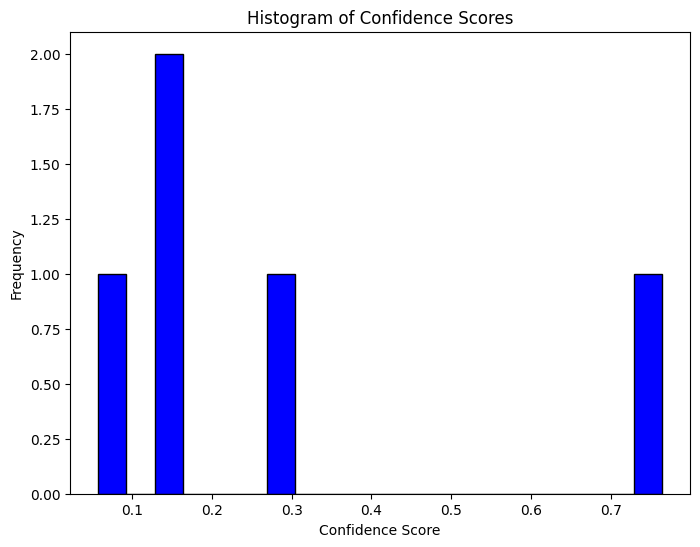

In [118]:
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_gradients(self, module, grad_input, grad_output):
        """ Save gradients during backpropagation. """
        self.gradients = grad_output[0]

    def save_feature_maps(self, module, input, output):
        """ Save feature maps during forward pass. """
        self.feature_maps = output

    def generate_cam(self):
        """ Generate Grad-CAM++ heatmap. """
        gradients = self.gradients
        feature_maps = self.feature_maps

        gradients_power_2 = gradients ** 2
        gradients_power_3 = gradients ** 3
        alpha_numer = gradients_power_2
        alpha_denom = (
            2 * gradients_power_2 + torch.sum(feature_maps * gradients_power_3, dim=(2, 3), keepdim=True)
        ).clamp(min=1e-10)
        alpha = alpha_numer / alpha_denom

        weights = alpha * torch.relu(gradients)

        cam = torch.sum(weights * feature_maps, dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize the CAM to the range [0, 1]
        if np.max(cam) != 0:  # Avoid division by zero
            cam = cam / np.max(cam)
        else:
            print("Warning: CAM has all zeros. Skipping normalization.")
        
        return cam


# Load your custom trained YOLO model
model = YOLO("/kaggle/working/yolov5su.pt")  # Change to your model's path
model.eval()

torch.set_grad_enabled(True)

# List of image paths (ensure you have at least 5 images)
image_paths = [
    "/kaggle/working/caltech_split/val/anchor/image_0009.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/Faces_easy/image_0023.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/brain/image_0019.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/butterfly/image_0026.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/cougar_body/image_0013.jpg"   # Change to your images
]

# True labels (for confusion matrix), you need to match these with your actual labels
true_labels = [0, 1, 2, 3, 4]  # Example: 0 for anchor, 1 for faces_easy, etc.
predicted_labels = []
confidence_scores = []

# Loop through the images and process them
for i, image_path in enumerate(image_paths):
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue  # Skip to the next image

    # Read and process the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image {image_path}. Skipping...")
        continue  # Skip to the next image

    input_image = cv2.resize(image, (640, 640))
    input_tensor = (
        torch.tensor(input_image.transpose(2, 0, 1))
        .float()
        .unsqueeze(0)
        .div(255.0)
        .requires_grad_()
    )

    # Choose target layer based on your model architecture
    target_layer = model.model.model[-3]  # This is typically the last convolutional layer, but might vary
    grad_cam_plus_plus = GradCAMPlusPlus(model, target_layer)

    # Get model predictions
    output = model.model(input_tensor)

    # Process output from YOLO (get confidence values for each detection)
    raw_predictions = output[0]
    raw_predictions = raw_predictions.permute(0, 2, 1)

    # Extract confidence values and predicted labels
    confidences = raw_predictions[0, :, 4]
    predicted_labels_batch = torch.argmax(raw_predictions[0, :, 5:], dim=1)

    # Find the detection with the highest confidence for each image
    if len(confidences) > 0:
        max_confidence_idx = confidences.argmax().item()  # Index of highest confidence
        predicted_labels.append(predicted_labels_batch[max_confidence_idx].item())
        confidence_scores.append(confidences[max_confidence_idx].item())
    else:
        predicted_labels.append(-1)  # If no detections, use -1
        confidence_scores.append(0)

    # Zero out the gradients and perform a backward pass
    model.zero_grad()
    target_score = confidences[max_confidence_idx]  # Use the target score of the max confidence
    target_score.backward(retain_graph=True)

    # Generate the Grad-CAM++ heatmap
    heatmap = grad_cam_plus_plus.generate_cam()

    # Resize the heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

    # Save the output with overlay
    output_path = f"/kaggle/working/grad_cam_output_{i + 1}.jpg"  # Save with a unique filename
    cv2.imwrite(output_path, overlay)
    print(f"Grad-CAM++ output for image {i + 1} saved at {output_path}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Anchor', 'Faces_easy', 'Brain', 'Butterfly', 'Chair'], yticklabels=['Anchor', 'Faces_easy', 'Brain', 'Butterfly', 'Chair'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Bar Chart for Confidence Scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(confidence_scores)), confidence_scores, color='green')
plt.xlabel('Image Index')
plt.ylabel('Confidence Score')
plt.title('Confidence Scores for Each Image')
plt.show()

# Box Plot for Confidence Distribution
plt.figure(figsize=(8, 6))
plt.boxplot(confidence_scores)
plt.ylabel('Confidence Score')
plt.title('Box Plot of Confidence Scores')
plt.show()

# Histogram of Confidence Scores
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=20, color='blue', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Histogram of Confidence Scores')
plt.show()


Grad-CAM++ output for image 1 saved at /kaggle/working/grad_cam_output_1.jpg
Grad-CAM++ output for image 2 saved at /kaggle/working/grad_cam_output_2.jpg
Grad-CAM++ output for image 3 saved at /kaggle/working/grad_cam_output_3.jpg
Grad-CAM++ output for image 4 saved at /kaggle/working/grad_cam_output_4.jpg
Grad-CAM++ output for image 5 saved at /kaggle/working/grad_cam_output_5.jpg


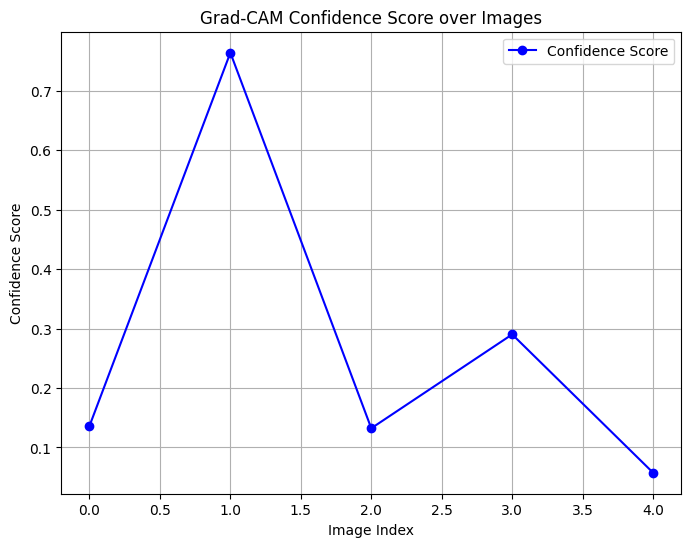

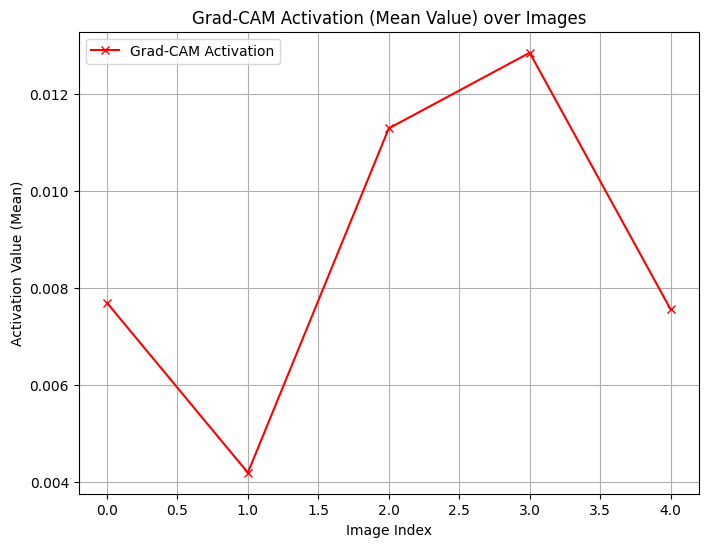

In [119]:
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_gradients(self, module, grad_input, grad_output):
        """ Save gradients during backpropagation. """
        self.gradients = grad_output[0]

    def save_feature_maps(self, module, input, output):
        """ Save feature maps during forward pass. """
        self.feature_maps = output

    def generate_cam(self):
        """ Generate Grad-CAM++ heatmap. """
        gradients = self.gradients
        feature_maps = self.feature_maps

        gradients_power_2 = gradients ** 2
        gradients_power_3 = gradients ** 3
        alpha_numer = gradients_power_2
        alpha_denom = (
            2 * gradients_power_2 + torch.sum(feature_maps * gradients_power_3, dim=(2, 3), keepdim=True)
        ).clamp(min=1e-10)
        alpha = alpha_numer / alpha_denom

        weights = alpha * torch.relu(gradients)

        cam = torch.sum(weights * feature_maps, dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize the CAM to the range [0, 1]
        if np.max(cam) != 0:  # Avoid division by zero
            cam = cam / np.max(cam)
        else:
            print("Warning: CAM has all zeros. Skipping normalization.")
        
        return cam


# Load your custom trained YOLO model
model = YOLO("/kaggle/working/yolov5su.pt")  # Change to your model's path
model.eval()

torch.set_grad_enabled(True)

# List of image paths (ensure you have at least 5 images)
image_paths = [
    "/kaggle/working/caltech_split/val/anchor/image_0009.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/Faces_easy/image_0023.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/brain/image_0019.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/butterfly/image_0026.jpg",  # Change to your images
    "/kaggle/working/caltech_split/val/cougar_body/image_0013.jpg"   # Change to your images
]

# True labels (for confusion matrix), you need to match these with your actual labels
true_labels = [0, 1, 2, 3, 4]  # Example: 0 for anchor, 1 for faces_easy, etc.
predicted_labels = []
confidence_scores = []

# Track Grad-CAM activations over images
grad_cam_activations = []  # List to store the activation values for each image

# Loop through the images and process them
for i, image_path in enumerate(image_paths):
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue  # Skip to the next image

    # Read and process the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image {image_path}. Skipping...")
        continue  # Skip to the next image

    input_image = cv2.resize(image, (640, 640))
    input_tensor = (
        torch.tensor(input_image.transpose(2, 0, 1))
        .float()
        .unsqueeze(0)
        .div(255.0)
        .requires_grad_()
    )

    # Choose target layer based on your model architecture
    target_layer = model.model.model[-3]  # This is typically the last convolutional layer, but might vary
    grad_cam_plus_plus = GradCAMPlusPlus(model, target_layer)

    # Get model predictions
    output = model.model(input_tensor)

    # Process output from YOLO (get confidence values for each detection)
    raw_predictions = output[0]
    raw_predictions = raw_predictions.permute(0, 2, 1)

    # Extract confidence values and predicted labels
    confidences = raw_predictions[0, :, 4]
    predicted_labels_batch = torch.argmax(raw_predictions[0, :, 5:], dim=1)

    # Find the detection with the highest confidence for each image
    if len(confidences) > 0:
        max_confidence_idx = confidences.argmax().item()  # Index of highest confidence
        predicted_labels.append(predicted_labels_batch[max_confidence_idx].item())
        confidence_scores.append(confidences[max_confidence_idx].item())
    else:
        predicted_labels.append(-1)  # If no detections, use -1
        confidence_scores.append(0)

    # Zero out the gradients and perform a backward pass
    model.zero_grad()
    target_score = confidences[max_confidence_idx]  # Use the target score of the max confidence
    target_score.backward(retain_graph=True)

    # Generate the Grad-CAM++ heatmap
    heatmap = grad_cam_plus_plus.generate_cam()

    # Track the Grad-CAM activation for each image
    grad_cam_activations.append(np.mean(heatmap))  # We use the mean activation value for tracking

    # Resize the heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

    # Save the output with overlay
    output_path = f"/kaggle/working/grad_cam_output_{i + 1}.jpg"  # Save with a unique filename
    cv2.imwrite(output_path, overlay)
    print(f"Grad-CAM++ output for image {i + 1} saved at {output_path}")


# Plotting Grad-CAM Learning Curves (Confidence Scores & Activation Values)

# Plot Confidence Scores over Images
plt.figure(figsize=(8, 6))
plt.plot(confidence_scores, marker='o', linestyle='-', color='b', label='Confidence Score')
plt.title('Grad-CAM Confidence Score over Images')
plt.xlabel('Image Index')
plt.ylabel('Confidence Score')
plt.grid(True)
plt.legend()
plt.show()

# Plot Grad-CAM Activations over Images
plt.figure(figsize=(8, 6))
plt.plot(grad_cam_activations, marker='x', linestyle='-', color='r', label='Grad-CAM Activation')
plt.title('Grad-CAM Activation (Mean Value) over Images')
plt.xlabel('Image Index')
plt.ylabel('Activation Value (Mean)')
plt.grid(True)
plt.legend()
plt.show()


In [122]:
!df -h

Filesystem                                                              Size  Used Avail Use% Mounted on
overlay                                                                 7.9T  6.0T  2.0T  76% /
tmpfs                                                                    64M     0   64M   0% /dev
shm                                                                      14G   12K   14G   1% /dev/shm
/dev/loop1                                                               20G   16G  3.6G  82% /kaggle/lib
192.168.7.2:/data/kagglesdsdata/datasets/6501850/10501851/d74teh4dkno0   78T   57T   21T  74% /kaggle/input/caltech
/dev/sda1                                                               122G   22G  101G  18% /opt/bin
/dev/mapper/snap                                                        7.9T  6.0T  2.0T  76% /etc/hosts
tmpfs                                                                    16G     0   16G   0% /proc/acpi
tmpfs                                                         

In [123]:
!rm -rf /root/.cache/*
!rm -rf /tmp/*

In [124]:
!rm -rf /path/to/unwanted/files